In [25]:
import os
from pathlib import Path
import laspy
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor

In [35]:
import os
from pathlib import Path
import laspy
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import pandas as pd

def makeGrid(pathin, pathout_m3c2, pathout_cluster, polys, res):
    """
    Reads in a LAS file and a shapefile of polygons, calculates the mean of M3C2 distance 
    (absolute value) of points within each polygon for 1-meter height bins, and writes the result to two separate CSV files:
    one for M3C2 distance and one for cluster ID.

    Also plots the grid with Polygon ID on the x-axis and Z value on the y-axis, even for bins with no points.

    Parameters:
    pathin (str): Path to the input LAS file.
    pathout_m3c2 (str): Path to the output CSV file for M3C2 distances.
    pathout_cluster (str): Path to the output CSV file for Cluster IDs.
    polys (str): Path to the shapefile of polygons.
    """
    display(pathin)
    # Read the input LAS file
    with laspy.open(pathin) as las_file:
        las = las_file.read()

    # Extract XYZ coordinates, M3C2 distances, and ClusterID (assumed stored as extra fields)
    try:
        points = np.vstack((las.x, las.y, las.z, las['M3C2 distance'], las['ClusterID'])).T
    except:
        m3c2_column = next(col for col in las.point_format.dimension_names if 'm3c2' in col.lower())
        points = np.vstack((las.x, las.y, las.z, las[m3c2_column], las['ClusterID'])).T

    # Filter points where ClusterID is NOT -1
    points = points[points[:, 4] != -1]

    # Take absolute value of M3C2 Distance
    points[:, 3] = np.abs(points[:, 3])

    # Read the shapefile containing the polygons
    polygons = gpd.read_file(polys)

    # Create a GeoDataFrame from the LAS points
    gdf_points = gpd.GeoDataFrame(
        points, 
        columns=['X', 'Y', 'Z', 'M3C2 Distance', 'ClusterID'],
        geometry=[Point(x, y) for x, y in zip(points[:, 0], points[:, 1])]
    )
    

    # Initialize lists to hold results for M3C2 distances and Cluster IDs
    results_m3c2 = []
    results_cluster = []

    # vertical bins
    z_bins = np.arange(0, 30, res)

    # Loop through each polygon and calculate the mean M3C2 distance and mode of Cluster ID for Z-bins
    for i, polygon in polygons.iterrows():

        # display(polygon.geometry)
        # display(gdf_points.geometry)

        points_in_polygon = gdf_points[gdf_points.within(polygon.geometry)]
        # print the number of pointds in the polygon
        if len(points_in_polygon) != 0:
            print(f"Polygon {i} contains {len(points_in_polygon)} points")


        # Initialize dictionaries to store results for each polygon and each Z-bin
        polygon_result_m3c2 = {'Polygon_ID': i}
        polygon_result_cluster = {'Polygon_ID': i}

        # Loop through each Z-bin
        for z in range(len(z_bins) - 1):
            # Select points within this Z-bin
            points_in_bin = points_in_polygon[
                (points_in_polygon['Z'] >= z_bins[z]) & (points_in_polygon['Z'] < z_bins[z+1])
            ]
            
            if len(points_in_bin) > 0:
                # Compute the median absolute M3C2 distance for this Z-bin
                mean_m3c2_in_bin = points_in_bin['M3C2 Distance'].median()
                cluster_id = points_in_bin['ClusterID'].mode().values[0]
            else:
                # If no points in this bin, set the values to NaN
                mean_m3c2_in_bin = np.nan
                cluster_id = np.nan

            # Add the results for this bin to the respective dictionaries
            polygon_result_m3c2[f'M3C2_{z*res}m'] = float(mean_m3c2_in_bin)
            polygon_result_cluster[f'ClusterID_{z*res}m'] = float(cluster_id)

        # Append the results for this polygon to the main results lists
        results_m3c2.append(polygon_result_m3c2)
        results_cluster.append(polygon_result_cluster)

    # Create DataFrames to store the results
    df_results_m3c2 = pd.DataFrame(results_m3c2)
    df_results_cluster = pd.DataFrame(results_cluster)

    # Write the results to separate CSV files
    df_results_m3c2.to_csv(pathout_m3c2, index=False)
    df_results_cluster.to_csv(pathout_cluster, index=False)

    print(f"Results written to {pathout_m3c2} and {pathout_cluster}")

    return df_results_m3c2, df_results_cluster



def process_all_files(base_dir, polys, res, overwrite=False):
    """
    Loops through all subfolders in base_dir, finds all erosion2_dbscan.las files, 
    and applies makeGrid to each, saving the output to the same subfolder where the LAS file is located.

    Parameters:
    base_dir (str): The base directory containing subfolders with erosion2_dbscan.las files.
    polys (str): Path to the shapefile of polygons.
    res (float): Height bin resolution for makeGrid.
    overwrite (bool): If False, skips processing files if output CSV already exists.
    """

    # Ensure correct UNC path formatting for Windows
    base_dir = Path(base_dir)
    
    # Loop through each subfolder in the base directory
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file == "erosion2_dbscan.las":
                # Full path to the erosion2_dbscan.las file
                las_file_path = Path(root) / file

                # Extract the folder name
                folder_name = Path(root).name

                # Define the output CSV file path using the folder name + _grid.csv
                output_csv_path = Path(root) / f"{folder_name}_grid_10x10cm.csv" ################## change for resolution cases
                output_csv_cluster_path = Path(root) / f"{folder_name}_clusters_10x10cm.csv"

                # Check if the output file already exists and if we should overwrite it
                if not overwrite and output_csv_path.exists() and output_csv_cluster_path.exists():
                    print(f"Skipping {las_file_path} as output files already exist and overwrite is set to False.")
                    continue

                # Apply the makeGrid function if the file does not exist or overwrite is True
                makeGrid(las_file_path, output_csv_path, output_csv_cluster_path, polys, res)

                #print(f"Processed: {las_file_path}")


In [36]:
# 10 cm resolution try
base_dir = "/Volumes/group/LiDAR/LidarProcessing/changedetection_m3c2/grid_output"
polys = "/Volumes/group/LiDAR/LidarProcessing/changedetection_m3c2/polygons_10cm/transects10cm_v3.shp"
# polys = "/Volumes/group/LiDAR/LidarProcessing/changedetection_m3c2/polygons_1m/PolygonesDelMar1m.shp"


res = .1  # Height bin resolution

# Run the processing function
process_all_files(base_dir, polys, res, overwrite=True) # change path names for different resolutions

PosixPath('/Volumes/group/LiDAR/LidarProcessing/changedetection_m3c2/grid_output/20180201_567_636_to_20180209_590_622/erosion2_dbscan.las')

Polygon 3226 contains 8 points
Polygon 3227 contains 10 points
Polygon 3229 contains 4 points
Polygon 3230 contains 2 points
Polygon 3231 contains 2 points
Polygon 3232 contains 4 points
Polygon 3318 contains 3 points
Polygon 3319 contains 6 points
Polygon 3320 contains 4 points
Polygon 3321 contains 1 points
Polygon 3322 contains 2 points
Polygon 3323 contains 7 points
Polygon 3324 contains 5 points
Polygon 3325 contains 4 points
Polygon 3327 contains 1 points
Polygon 3504 contains 2 points
Polygon 3505 contains 7 points
Polygon 3506 contains 16 points
Polygon 3507 contains 3 points
Polygon 3508 contains 4 points
Polygon 3509 contains 2 points
Polygon 7715 contains 2 points
Polygon 7716 contains 3 points
Polygon 7717 contains 2 points
Polygon 7718 contains 4 points
Polygon 7719 contains 9 points
Polygon 7720 contains 6 points
Polygon 7721 contains 7 points
Polygon 7722 contains 1 points
Polygon 7723 contains 3 points
Polygon 13654 contains 1 points
Polygon 13655 contains 2 points
Poly

PosixPath('/Volumes/group/LiDAR/LidarProcessing/changedetection_m3c2/grid_output/20230905_567_763_to_20230914_567_768/erosion2_dbscan.las')

KeyboardInterrupt: 

In [ ]:
# IWA paths 
# 10 cm resolution try
base_dir = "/project/group/LiDAR/LidarProcessing/changedetection_m3c2/grid_output"
polys = "/project/group/LiDAR/LidarProcessing/changedetection_m3c2/polygons_10cm/transects10cm_v3.shp"
# polys = "/Volumes/group/LiDAR/LidarProcessing/changedetection_m3c2/polygons_1m/PolygonesDelMar1m.shp"


res = .1  # Height bin resolution

# Run the processing function
process_all_files(base_dir, polys, res, overwrite=True) # change path names for different resolutions

In [41]:
grid = pd.read_csv("/Volumes/group/LiDAR/LidarProcessing/changedetection_m3c2/grid_output/20180201_567_636_to_20180209_590_622/20180201_567_636_to_20180209_590_622_grid_10x10cm.csv")

# number of cells that arent nan
cells = grid.notna().sum().sum()
cells

33389

In [16]:
polys = "/Volumes/group/LiDAR/LidarProcessing/changedetection_m3c2/polygons_10cm/transects10cm_v3.shp"
polygons = gpd.read_file(polys)
polygons

,Id,Shape_Leng,Shape_Area,geometry
0,0,4000.127388,112.987826,"POLYGON ((476587.228 3644382.346, 474628.709 3..."
1,0,4000.151101,173.806163,"POLYGON ((476587.203 3644382.467, 475605.755 3..."
2,0,4000.266703,231.861053,"POLYGON ((476587.172 3644382.613, 475615.231 3..."
3,0,4000.266376,231.487354,"POLYGON ((476587.142 3644382.758, 475595.853 3..."
4,0,4000.285444,241.230230,"POLYGON ((476587.112 3644382.903, 475615.189 3..."
...,...,...,...,...
31936,0,4000.301851,251.211781,"POLYGON ((475911.093 3647348.944, 474923.497 3..."
31937,0,4000.128805,164.158333,"POLYGON ((475911.084 3647349.072, 474906.397 3..."
31938,0,4000.278147,239.177362,"POLYGON ((475911.076 3647349.201, 474923.484 3..."
31939,0,4000.128677,164.249508,"POLYGON ((475911.068 3647349.329, 474906.384 3..."


0.0

/opt/anaconda3/envs/m3c2/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6834: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/anaconda3/envs/m3c2/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6835: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

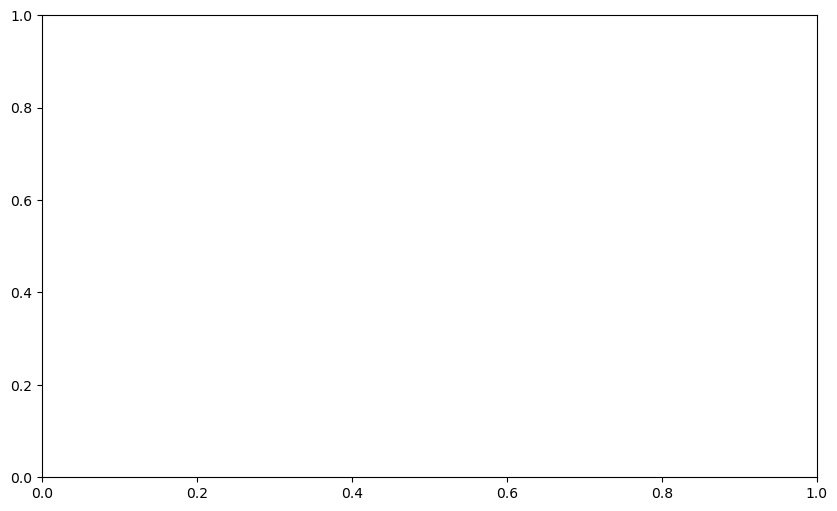

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/Volumes/group/LiDAR/LidarProcessing/changedetection_m3c2/grid_output/20170411_588_621_to_20170420_590_622/20170411_588_621_to_20170420_590_622_grid_10x10cm.csv")

# display(df)

x = df.iloc[:, 1:]

display(x.sum().sum())